# Pima diabetes - part II
The first diabetes study reached a few conclusions: 
- The data set is skewed - filtered by the original researchers to exclude results with high glucose levels
- Initial screening (without blood tests) reaches 70% accuracy and full testing reaches 75% accuracy.

## Questions for further study
We hope to achieve higher accuracy, possibly through unsupervised learning. 

Can k-means or PCA deliver? Let's see what happens if we perform unsupervised before supervised.

## Data limitations
The study is biased in a number of important ways:
- **Data has been filtered to remove samples with glucose levels > 200 (positive test for diabetes)**; severe diabetics have been subtly excluded from study.
- Limited to women over 21 years old; men and children may see different patterns of diabetes
- Limited to Pima Indians; they were studied specifically because of a genetic abnormality affecting diabetes
- Conducted in 1990; American diets have changed drastically since then, with a large uptick in diabetes
- The cost of blood tests was estimated in 1990. Glucose finger sticks can now be conducted quickly and cost approximately $0.25.

## Features

A number of features in this dataset should be relevant for predicting diabetes. I have written preliminary notes about their usefulness in our analysis along with each field:
- ** Number of times pregnant**
- **Plasma glucose concentration a 2 hours in an oral glucose tolerance test** 
- **Diastolic blood pressure (mm Hg)**
- **Triceps skin fold thickness (mm)** - may have a negative coefficient when used together with BMI
- **2-Hour serum insulin (mu U/ml)** - correlated with glucose
- **Body mass index (weight in kg/(height in m)^2)**
- **Diabetes pedigree function** - Do relatives have diabetes?
- **Age (years)** - Diabetes is either congenital (Type I) or develops over time in correlation with other factors (Type II). The data may show interaction with different predictors, depending on age of diagnosis. Also, older people have more time to have had their disease diagnosed.

A quick look at the data shows some factors obviously correlate well with diabetes. 
- Diabetics have a mean BMI of 35 vs 30 for non-diabetics
- Diabetics have a mean glucose test of 140 vs 115 for non-diabetics
- Diabetics have a mean age of 36 vs 31 for non-diabetics

### New features
Other features may prove useful:
- **Pregnant^2** - I expect a single pregnancy to have a large effect (see postscript)
- **Skin\*BMI** - I expect these to interact (see postscript) 
- **BMI^2** - The effect may be more complex than linear

## Null values and correlations
Zeros appear in many columns (example: glucose) where they are biologically impossible. I assume these zeros indicate null.

Pregnancies are correlated with age (makes sense on reflection). They both should be investigated, as they may have different effects.

Most fields are almost entirely populated - and the missing values should be imputed. The insulin test was only completed 51%  of the time (394/768). The missing rows should be dropped.

As expected, glucose and insulin are highly correlated (58%). This correlation leaves open the possibility of dropping one of these tests without adverse effect.

Other fields show correlation:
- Age and pregnancy (54%): women have more babies as they grow older. There is slightly less correlation with pregnancy^2 (49%), making pregnancy a good candidate for dropping
- Skin fold and bmi (65%): fatter people are likely to carry subcutaneous fat. However, I expect the possibility of a complex interaction (see postscript) and am open to keeping both fields

The constructed fields naturally show high correlation with the fields they were built from, but the models may benefit from keeping all fields:
- Pregnancies and pregnancies^2 (94%)
- Skin fold and skin fold * bmi (94%)
- BMI and skin fold * bmi (85%)

I propose four different statistical studies that will help us investigate possible testing strategies:
1. All fields, except blood tests
2. All fields, except insulin test, dropping rows with null glucose
3. All fields, except glucose test, dropping rows with null insulin
4. All fields, dropping rows with null glucose or insulin

### Dropped features
A few features were dropped because they proved to have low importance scores - pregnancies (0.051) and diastolic blood pressure (0.047). Pregnancies was also highly correlated with age and pregnancies ^ 2. 

Note: these features may have been more important before additional features were added.

## Conclusion
Each predictive model is expected to beat 67% accuracy - the accuracy of simply assuming the patient is diabetic. A better goal is 76% sensitivity / specificity (statistics from original study).

A number of statistical methods for each of the four models were attempted. Each brings its own assumed advantages, but the proof is in the (experimental) pudding.
- Naive Bayes - should work well with low amounts of training data, but has problems with correlated data
- Random forest is difficult to overfit, but it's difficult to explain the results
- k Nearest Neighbors is sensitive to irrelevant or correlated features

Different methods were superior for the different data sets. The accuracies for the glucose set were:
- Random Forest (68%) 
- kNN (75%)
- Naive Bayes (67%)
- Logistic Regression (75%)

The training curves for None and Glucose showed a reasonably flat slope on the right side of the graph, so our models had reasonable variance. We could improve these models by adding more predictors.

The training curves for Insulin and Both demonstrated some variance. They could be improved by reducing irrelevant predictors further.

For our purpose, speed is not very important (each method works in a blink); neither is interpretability (assuming doctors have a computer available). Interpretability would be more important if we were providing advice ("focus on your blood pressure").

Ultimately, the glucose test proved superior to either the insulin test or the combination of both (possibly because many cases did not contain insulin test results). 


### Recommendation
Based on what we see in the data:
1. Screen patients with no blood test (Logistic Regression - 70% accuracy). 
2. If they show a high likelihood of diabetes, follow with a glucose test (Logistic Regression - 75% accuracy).

However, the study filtered out the highest glucose tests (and glucose testing is now much cheaper). A repeated study would probably show more advantage in testing glucose.

### Postscript

I have personally performed my own research and self-experimentation in this area. Diabetes is part of a related complex of diseases (collectively referred to as "metabolic syndrome" in the medical literature):
- Heart disease
- Stroke
- Cancer
- Alzheimer's (according to some sources)

Specifically, I've been investigating an unorthodox hypothesis: **a root cause of all these diseases is physical compression of the pancreas, leading to poor regulation of glucose.** Glucose, while vital for the body, is highly reactive. It sets off many harmful biological cascades when levels are far different from homeostasis. 

There's a great deal of indirect evidence for this theory, including:
- People who sit (physical compression) for long periods are more likely to develop metabolic syndrome
- People with high central body mass (visceral rather than subcutaneous fat, leading to physical compression) are more likely to develop metabolic syndrome
- Pregnant women (physical compression) sometimes develop "gestational diabetes"
- Women are more likely than men to lay down fat subcutaneously, even though visceral fat is anatomically more efficient (imagine running with weights tied to your ankles vs. carried in a backpack)
- The pancreas is one of the few hormone glands that is not protected from physical pressure

This dataset holds particular interest for me. **Are you aware of other publically available diabetes datasets?**

### Further improvement
I hope to figure out / apply:
- Removing outliers from training set
- Tune each of the four data sets individually
- Tune the "none" algorithm towards recall (the learning curve was focused there)

## Analysis

In [62]:
# Mike Schoeffler
# Reviewer(s): Roger Zuniga (any remaining errors are my own)
# 2/5/16 Set up data import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use ggplot style everywhere
# show graphs in notebook
% matplotlib inline 

### Import data

In [63]:
# import the diabetes data set
# change 0s in particular columns (but not all) to null
pima_diabetes = pd.read_csv('pima-indians-diabetes.data', 
    names = ['pregnancies', 'glucose', 'dbp', 'skin_fold', 'insulin', 'bmi', 'pedigree', 'age', 'diabetic'],
    na_values={"glucose" : "0", "dbp" : "0", "skin_fold" : "0", "insulin" : "0", "bmi" : "0"})

# add more features
pima_diabetes['pregnancies2'] = pima_diabetes['pregnancies'] ** 2
pima_diabetes['skin_bmi'] = pima_diabetes['skin_fold'] * pima_diabetes['bmi']
pima_diabetes['bmi2'] = pima_diabetes['bmi'] ** 2

### Explore

In [64]:
pima_diabetes.head()

,pregnancies,glucose,dbp,skin_fold,insulin,bmi,pedigree,age,diabetic,pregnancies2,skin_bmi,bmi2
0,6,148.000,72.000,35.000,nan,33.600,0.627,50,1,36,1176.000,1128.960
1,1,85.000,66.000,29.000,nan,26.600,0.351,31,0,1,771.400,707.560
2,8,183.000,64.000,nan,nan,23.300,0.672,32,1,64,nan,542.890
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,646.300,789.610
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,1508.500,1857.610


### Summary statistics

In [65]:
pima_diabetes.describe()

,pregnancies,glucose,dbp,skin_fold,insulin,bmi,pedigree,age,diabetic,pregnancies2,skin_bmi,bmi2
count,768.000,763.000,733.000,541.000,394.000,757.000,768.000,768.000,768.000,768.000,539.000,757.000
mean,3.845,121.687,72.405,29.153,155.548,32.457,0.472,33.241,0.349,26.124,1006.413,1101.379
std,3.370,30.536,12.382,10.477,118.776,6.925,0.331,11.760,0.477,38.438,516.695,483.909
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000,0.000,137.200,331.240
25%,1.000,99.000,64.000,22.000,76.250,27.500,0.244,24.000,0.000,1.000,613.800,756.250
50%,3.000,117.000,72.000,29.000,125.000,32.300,0.372,29.000,0.000,9.000,938.600,1043.290
75%,6.000,141.000,80.000,36.000,190.000,36.600,0.626,41.000,1.000,36.000,1323.200,1339.560
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000,289.000,3742.200,4502.410


In [66]:
pima_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 12 columns):
pregnancies     768 non-null int64
glucose         763 non-null float64
dbp             733 non-null float64
skin_fold       541 non-null float64
insulin         394 non-null float64
bmi             757 non-null float64
pedigree        768 non-null float64
age             768 non-null int64
diabetic        768 non-null int64
pregnancies2    768 non-null int64
skin_bmi        539 non-null float64
bmi2            757 non-null float64
dtypes: float64(8), int64(4)
memory usage: 78.0 KB


In [67]:
pima_diabetes.corr()

,pregnancies,glucose,dbp,skin_fold,insulin,bmi,pedigree,age,diabetic,pregnancies2,skin_bmi,bmi2
pregnancies,1.000,0.128,0.214,0.100,0.082,0.022,-0.034,0.544,0.222,0.940,0.045,0.000
glucose,0.128,1.000,0.223,0.228,0.581,0.233,0.137,0.267,0.495,0.114,0.245,0.220
dbp,0.214,0.223,1.000,0.227,0.098,0.289,-0.003,0.330,0.171,0.207,0.278,0.292
skin_fold,0.100,0.228,0.227,1.000,0.185,0.648,0.115,0.167,0.259,0.120,0.935,0.620
insulin,0.082,0.581,0.098,0.185,1.000,0.228,0.130,0.220,0.303,0.057,0.200,0.206
bmi,0.022,0.233,0.289,0.648,0.228,1.000,0.155,0.026,0.314,0.064,0.849,0.988
pedigree,-0.034,0.137,-0.003,0.115,0.130,0.155,1.000,0.034,0.174,-0.009,0.163,0.157
age,0.544,0.267,0.330,0.167,0.220,0.026,0.034,1.000,0.238,0.487,0.120,0.011
diabetic,0.222,0.495,0.171,0.259,0.303,0.314,0.174,0.238,1.000,0.219,0.292,0.298
pregnancies2,0.940,0.114,0.207,0.120,0.057,0.064,-0.009,0.487,0.219,1.000,0.088,0.048


## Create four datasets for different screening strategies

In [68]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# experiment w dropping low importance variables
pima_diabetes_copy = pima_diabetes.drop(['pregnancies', 'dbp'], axis=1)

# standardization: bring all of our features onto the same scale
stdsc = StandardScaler()

pima_neither = pima_diabetes_copy.drop(['glucose', 'insulin'], axis=1)
# the dropped rows may bias the means - use means from this particular dataset 
pima_neither = pima_neither.fillna(pima_neither.mean())
X_neither_std = stdsc.fit_transform(pima_neither.drop('diabetic', axis=1))
X_train_neither, X_test_neither, y_train_neither, y_test_neither = train_test_split(
    X_neither_std, pima_neither['diabetic'],
    test_size=0.2, random_state=7)

pima_glucose = pima_diabetes_copy.drop('insulin', axis=1).dropna(subset=['glucose'])
# the dropped rows may bias the means - use means from this particular dataset 
pima_glucose = pima_glucose.fillna(pima_glucose.mean())
pima_glucose_std = stdsc.fit_transform(pima_glucose)
X_glucose_std = stdsc.fit_transform(pima_glucose.drop('diabetic', axis=1))
X_train_glucose, X_test_glucose, y_train_glucose, y_test_glucose = train_test_split(
    X_glucose_std, pima_glucose['diabetic'], 
    test_size=0.2, random_state=7)

pima_insulin = pima_diabetes_copy.drop('glucose', axis=1).dropna(subset=['insulin'])
# the dropped rows may bias the means - use means from this particular dataset 
pima_insulin = pima_insulin.fillna(pima_insulin.mean())
pima_insulin_std = stdsc.fit_transform(pima_insulin)
X_insulin_std = stdsc.fit_transform(pima_insulin.drop('diabetic', axis=1))
X_train_insulin, X_test_insulin, y_train_insulin, y_test_insulin = train_test_split(
    X_insulin_std, pima_insulin['diabetic'], 
    test_size=0.2, random_state=7)

pima_both = pima_diabetes_copy.dropna(subset = ['insulin', 'glucose'], how = 'any')
# the dropped rows may bias the means - use means from this particular dataset 
pima_both = pima_both.fillna(pima_both.mean())
pima_both_std = stdsc.fit_transform(pima_both)
X_both_std = stdsc.fit_transform(pima_both.drop('diabetic', axis=1))
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(
    X_both_std, pima_both['diabetic'], 
    test_size=0.2, random_state=7)

pima_both_start = pima_diabetes.dropna(subset = ['insulin', 'glucose'], how = 'any')
# the dropped rows may bias the means - use means from this particular dataset 
pima_both_start = pima_both_start.fillna(pima_both_start.mean())
pima_both_start_std = stdsc.fit_transform(pima_both_start)
X_both_start_std = stdsc.fit_transform(pima_both_start.drop('diabetic', axis=1))
X_train_both_start, X_test_both_start, y_train_both_start, y_test_both_start = train_test_split(
    X_both_start_std, pima_both_start['diabetic'], 
    test_size=0.2, random_state=7)

y_train_glucose.head()

673    0
424    1
749    1
430    0
291    1
Name: diabetic, dtype: int64

In [69]:
X_train_both.shape

(314, 9)

In [70]:
y_train_both.shape

(314,)

### Find minimum accuracy for the data sets used in testing each strategy

In [71]:
# how many have diabetes?
y_test_neither.value_counts() / y_test_neither.shape[0]

0   0.630
1   0.370
Name: diabetic, dtype: float64

In [72]:
# how many have diabetes?
y_test_glucose.value_counts() / y_test_glucose.shape[0]

0   0.641
1   0.359
Name: diabetic, dtype: float64

In [73]:
# how many have diabetes?
y_test_insulin.value_counts() / y_test_insulin.shape[0]

0   0.671
1   0.329
Name: diabetic, dtype: float64

In [74]:
# how many have diabetes?
y_test_both.value_counts() / y_test_both.shape[0]

0   0.608
1   0.392
Name: diabetic, dtype: float64

## Visualize data

In [75]:
g = sns.pairplot(pima_neither, hue="diabetic", palette="Set2", diag_kind="kde", size=2.5)

NameError: name 'sns' is not defined

In [ ]:
sns.factorplot(x='diabetic', 
               y='bmi',
               kind='bar',
              data = pima_neither)

In [ ]:
sns.factorplot(x='diabetic', 
               y='glucose',
               kind='bar',
              data = pima_glucose)

In [ ]:
sns.factorplot(x='diabetic', 
               y='age',
               kind='bar',
              data = pima_neither)

## Build predictions for each model

### kNN

In [ ]:
# %%timeit # times cell
# 10 cross validation iterations with 20% test / 80% train
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train_both.shape[0], n_iter=10, test_size=0.2, random_state=0)
# k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
# starting with k=1
# this creates the classifier
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', p=2)
# execute this to fit the classifier to our data
# knn.fit(X_no_tests, y_no_tests)
# execute this to predict the labels for our "unseen" test data
# knn.predict(test)

# gridsearch for hyperparameters
from sklearn.grid_search import GridSearchCV
# the parameters we want to search in a dictionary
# use the parameter name from sklearn as the key
# and the possible values you want to test as the values
parameters = {'n_neighbors': range(1,30), 'weights': ['uniform', 'distance'],
             'p': range(1,4)}
clf = GridSearchCV(knn, parameters, cv=cv)
clf.fit(X_train_both, y_train_both)
# get a list of all the combo scores
clf.best_params_

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_neither, y_train_neither)
# nb.fit(pima_neither.drop(['diabetic'],axis = 1), pima_neither['diabetic'])

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
logreg.fit(X_train_both, y_train_both)
logreg.coef_
parameters = {'C': np.linspace(1e-5, 10, 100), 'penalty': ['l1', 'l2']}
logreg2 = LogisticRegression()           
clf = GridSearchCV(logreg, parameters, cv=cv)
clf.fit(X_train_both, y_train_both)
clf.best_params_

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X_train_both, y_train_both)

parameters = {'n_estimators': range(1,40)}
clf = GridSearchCV(model, parameters, cv=cv)
clf.fit(X_train_both, y_train_both)
clf.best_params_

## Importance scores for original and added fields 

In [ ]:
rf_start = RandomForestClassifier(n_estimators = 20)
    
rf_start.fit(X_train_both_start, y_train_both_start)
features = pima_both_start.drop('diabetic', axis=1).columns
feature_importances = rf_start.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

## Add clustering to data sets

In [ ]:
scale = StandardScaler()
# fit and transform in one step
X_train_neither_scale = scale.fit_transform(X_train_neither)
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
x = []
y = []
for n in range(2,15):
    km2 = KMeans(n_clusters=n)
    centers = km2.fit_predict(X_train_neither_scale)
    x.append(n)
    y.append(silhouette_score(X_train_neither_scale, centers))
plt.plot(x, y)

In [ ]:

# get the cluster centers in the original scale
# this means you will have k cluster centers
# we pick k=5 based on elbow method
km = KMeans(n_clusters=5, n_init=20)
km.fit(X_scale)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
pd.DataFrame(columns, index=example.columns)

In [ ]:
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
x = []
y = []
for n in range(2,15):
    km2 = KMeans(n_clusters=n)
    centers = km2.fit_predict(X_train_glucose)
    x.append(n)
    y.append(silhouette_score(X_train_glucose, centers))
plt.plot(x, y)

In [ ]:
X_train_glucose.shape

In [ ]:

# get the cluster centers in the original scale
# this means you will have k cluster centers
# we pick k=3
km = KMeans(n_clusters=3, n_init=20)
km.fit(X_train_glucose)

km.cluster_centers_
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
#pd.DataFrame(columns, index=example.columns)

In [77]:
# X_train_glucose.append(km.predict(X_train_glucose))
X_train_glucose = pd.DataFrame(X_train_glucose)
X_test_glucose = pd.DataFrame(X_test_glucose)
#X_train_glucose['clusters'] = km.predict(X_train_glucose)
#X_test_glucose['clusters'] = km.predict(X_test_glucose)

In [78]:
X_train_glucose.head()

,0,1,2,3,4,5,6,7
0,0.043,0.666,3.614,1.228,-0.958,-0.447,2.310,4.541
1,0.961,0.324,1.519,0.131,0.232,0.981,0.847,1.538
2,1.321,0.000,-1.186,-0.888,1.422,0.254,-0.000,-1.063
3,-0.743,0.000,-1.492,-1.099,-0.873,-0.577,-0.000,-1.266
4,-0.481,0.097,0.603,0.858,-0.703,-0.681,0.212,0.496


In [81]:
X_train_glucose = pd.concat([X_train_glucose, pd.get_dummies(km.predict(X_train_glucose))], axis=1)  
X_train_glucose.head()

,0,1,2,3,4,5,6,7,0,1,2
0,0.043,0.666,3.614,1.228,-0.958,-0.447,2.310,4.541,0.000,0.000,1.000
1,0.961,0.324,1.519,0.131,0.232,0.981,0.847,1.538,0.000,0.000,1.000
2,1.321,0.000,-1.186,-0.888,1.422,0.254,-0.000,-1.063,1.000,0.000,0.000
3,-0.743,0.000,-1.492,-1.099,-0.873,-0.577,-0.000,-1.266,0.000,1.000,0.000
4,-0.481,0.097,0.603,0.858,-0.703,-0.681,0.212,0.496,0.000,0.000,1.000


0.73856209150326801

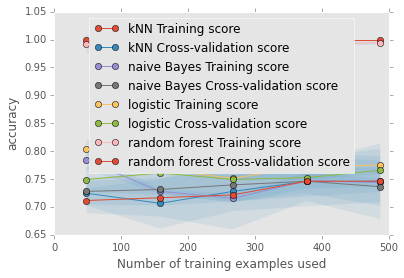

In [55]:
from sk_modelcurves.learning_curve import draw_learning_curve
rf = RandomForestClassifier(n_estimators = 15)
knn = KNeighborsClassifier(n_neighbors=7, p = 1, weights = 'distance')
nb = GaussianNB()
lr = LogisticRegression(C=0.2, penalty = 'l2')
draw_learning_curve([knn, nb, lr, rf], X_train_glucose, y_train_glucose, 
    estimator_titles=['kNN', 'naive Bayes', 'logistic', 'random forest'], cv=5,
    scoring='accuracy');
lr.fit(X_train_glucose, y_train_glucose)
lr.score(X_test_glucose, y_test_glucose)

0.68627450980392157

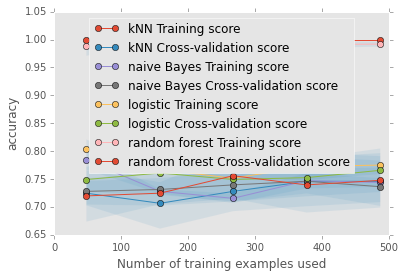

In [56]:
from sk_modelcurves.learning_curve import draw_learning_curve
rf = RandomForestClassifier(n_estimators = 15)
knn = KNeighborsClassifier(n_neighbors=7, p = 1, weights = 'distance')
nb = GaussianNB()
lr = LogisticRegression(C=0.2, penalty = 'l2')
draw_learning_curve([knn, nb, lr, rf], X_train_glucose, y_train_glucose, 
    estimator_titles=['kNN', 'naive Bayes', 'logistic', 'random forest'], cv=5,
    scoring='accuracy');
nb.fit(X_train_glucose, y_train_glucose)
nb.score(X_test_glucose, y_test_glucose)

## Learning curves for neither

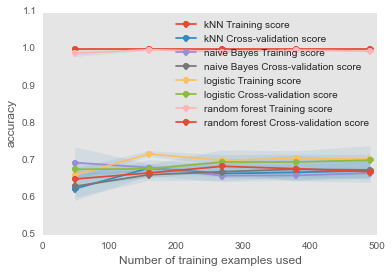

In [375]:
from sk_modelcurves.learning_curve import draw_learning_curve
rf = RandomForestClassifier(n_estimators = 15)
knn = KNeighborsClassifier(n_neighbors=7, p = 1, weights = 'distance')
nb = GaussianNB()
lr = LogisticRegression(C=0.2, penalty = 'l2')
draw_learning_curve([knn, nb, lr, rf], X_train_neither, y_train_neither, 
    estimator_titles=['kNN', 'naive Bayes', 'logistic', 'random forest'], cv=5,
    scoring='accuracy');

## Learning curves for glucose

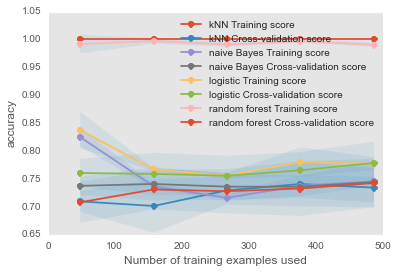

In [340]:
from sk_modelcurves.learning_curve import draw_learning_curve
rf = RandomForestClassifier(n_estimators = 15)
knn = KNeighborsClassifier(n_neighbors=7, p = 1, weights = 'distance')
nb = GaussianNB()
lr = LogisticRegression(C=0.2, penalty = 'l2')
draw_learning_curve([knn, nb, lr, rf], X_train_glucose, y_train_glucose, 
    estimator_titles=['kNN', 'naive Bayes', 'logistic', 'random forest'], cv=5,
    scoring='accuracy');

## Learning curves for insulin

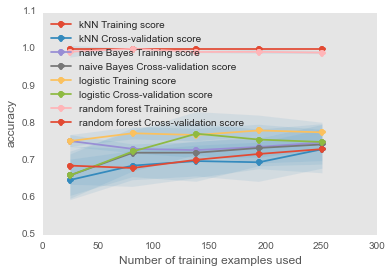

In [341]:
from sk_modelcurves.learning_curve import draw_learning_curve
rf = RandomForestClassifier(n_estimators = 15)
knn = KNeighborsClassifier(n_neighbors=7, p = 1, weights = 'distance')
nb = GaussianNB()
lr = LogisticRegression(C=0.2, penalty = 'l2')
draw_learning_curve([knn, nb, lr, rf], X_train_insulin, y_train_insulin, 
    estimator_titles=['kNN', 'naive Bayes', 'logistic', 'random forest'], cv=5,
    scoring='accuracy');

## Learning curves for both

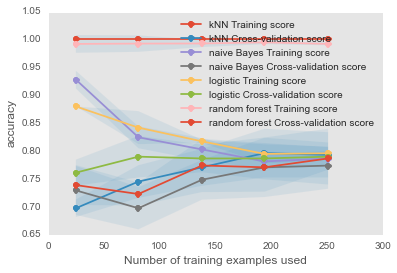

In [342]:
from sk_modelcurves.learning_curve import draw_learning_curve
rf = RandomForestClassifier(n_estimators = 15)
knn = KNeighborsClassifier(n_neighbors=7, p = 1, weights = 'distance')
nb = GaussianNB()
lr = LogisticRegression(C=0.2, penalty = 'l2')
draw_learning_curve([knn, nb, lr, rf], X_train_both, y_train_both, 
    estimator_titles=['kNN', 'naive Bayes', 'logistic', 'random forest'], cv=5,
    scoring='accuracy');

## Score for neither

In [351]:
rf.fit(X_train_neither, y_train_neither)
rf.score(X_test_neither, y_test_neither)

0.70129870129870131

In [352]:
knn.fit(X_train_neither, y_train_neither)
knn.score(X_test_neither, y_test_neither)

0.70129870129870131

In [353]:
nb.fit(X_train_neither, y_train_neither)
nb.score(X_test_neither, y_test_neither)

0.62987012987012991

In [354]:
lr.fit(X_train_neither, y_train_neither)
lr.score(X_test_neither, y_test_neither)

0.70129870129870131

## Score for glucose

In [355]:
rf.fit(X_train_glucose, y_train_glucose)
rf.score(X_test_glucose, y_test_glucose)

0.6797385620915033

In [356]:
knn.fit(X_train_glucose, y_train_glucose)
knn.score(X_test_glucose, y_test_glucose)

0.75163398692810457

In [357]:
nb.fit(X_train_glucose, y_train_glucose)
nb.score(X_test_glucose, y_test_glucose)

0.67320261437908502

In [358]:
lr.fit(X_train_glucose, y_train_glucose)
lr.score(X_test_glucose, y_test_glucose)

0.75163398692810457

## Score for insulin

In [359]:
rf.fit(X_train_insulin, y_train_insulin)
rf.score(X_test_insulin, y_test_insulin)

0.67088607594936711

In [360]:
knn.fit(X_train_insulin, y_train_insulin)
knn.score(X_test_insulin, y_test_insulin)

0.759493670886076

In [361]:
nb.fit(X_train_insulin, y_train_insulin)
nb.score(X_test_insulin, y_test_insulin)

0.63291139240506333

In [362]:
lr.fit(X_train_insulin, y_train_insulin)
lr.score(X_test_insulin, y_test_insulin)

0.65822784810126578

## Score for both

In [363]:
rf.fit(X_train_both, y_train_both)
rf.score(X_test_both, y_test_both)

0.72151898734177211

In [364]:
knn.fit(X_train_both, y_train_both)
knn.score(X_test_both, y_test_both)

0.69620253164556967

In [365]:
nb.fit(X_train_both, y_train_both)
nb.score(X_test_both, y_test_both)

0.68354430379746833

In [366]:
lr.fit(X_train_both, y_train_both)
lr.score(X_test_both, y_test_both)

0.74683544303797467